In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pr as erk

# Load the industry returns and the total market index we previously created
ind_return = erk.get_ind_returns()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
import numpy as np

risky_r = ind_return[["TECH", "TUR", "FIN"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r) #creat a data frame like risky_r
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

In [39]:
safe_r.shape

(107, 3)

In [42]:
print(safe_r)

           TECH     TUR     FIN
2015-02  0.0025  0.0025  0.0025
2015-03  0.0025  0.0025  0.0025
2015-04  0.0025  0.0025  0.0025
2015-05  0.0025  0.0025  0.0025
2015-06  0.0025  0.0025  0.0025
...         ...     ...     ...
2023-08  0.0025  0.0025  0.0025
2023-09  0.0025  0.0025  0.0025
2023-10  0.0025  0.0025  0.0025
2023-11  0.0025  0.0025  0.0025
2023-12  0.0025  0.0025  0.0025

[107 rows x 3 columns]


1. Cushion - (Asset Value minus floor value)
2. Compute an allocation to safe and risky assets -> m*risk budget
3. Recompute the asset value based on the returns

In [22]:
# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 4
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [23]:
for step in range(n_steps): # the budy of this loop is going to be executed for first with step, first with step equal to zero then with step equal to one 
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion # how much momey do I give to the risk yasset
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w # # how much momey do I give to the safe asset
    risky_alloc = account_value*risky_w # how many dolars hace you allocated to the risky asset
    safe_alloc = account_value*safe_w # how many dolars hace you allocated to the safe asset
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step]) # Grow the risky allocation by that return and grow the safe allocation by that return
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    risky_wealth = start*(1+risky_r).cumprod() # To compare, if I just stock my money in he risky asset, start with a 1000$ and then compounding it over time

<Axes: >

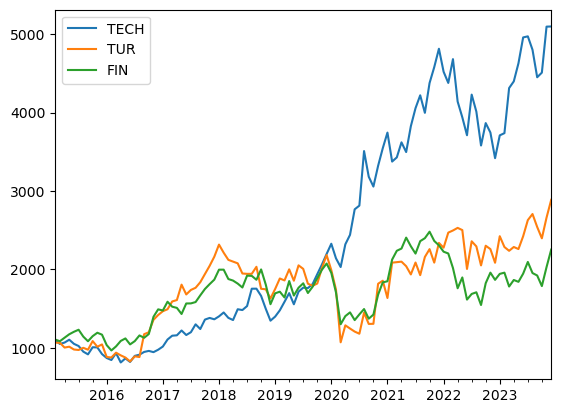

In [24]:
risky_wealth.plot()

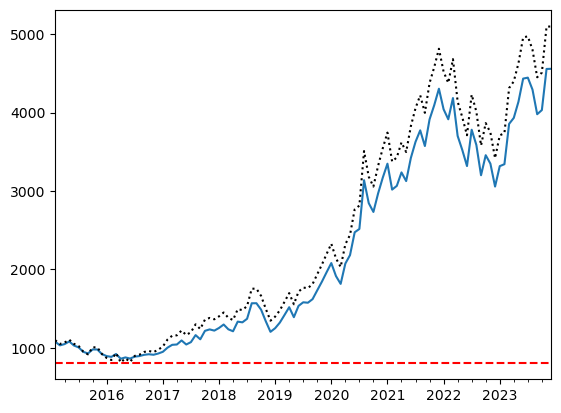

In [25]:
ind = "TECH"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

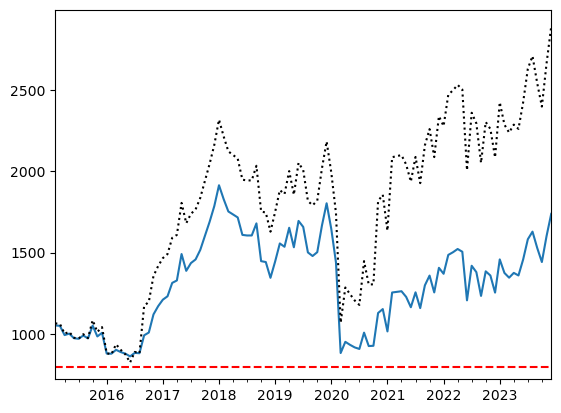

In [26]:
ind = "TUR"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

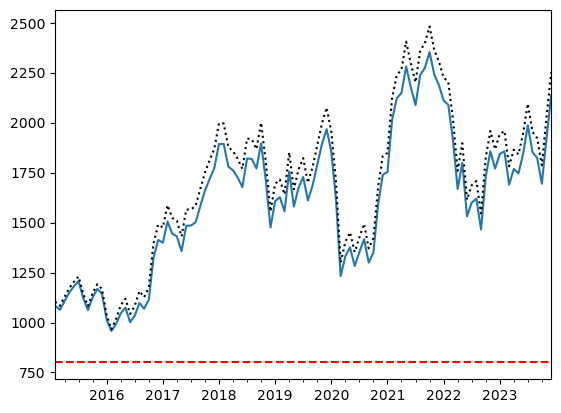

In [27]:
ind = "FIN"
ax = account_history[ind].plot()
risky_wealth[ind].plot(style="k:")
ax.axhline(y=floor_value, color='r', linestyle='--')

<Axes: >

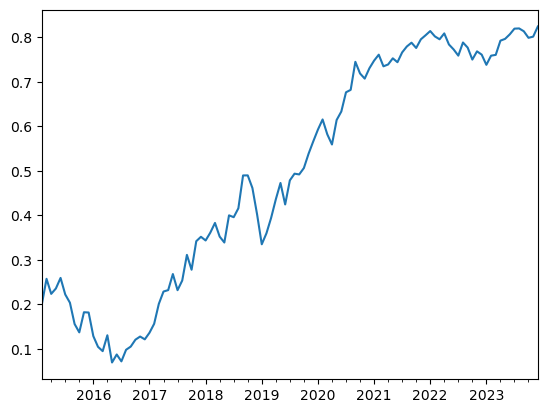

In [28]:
cushion_history["TECH"].plot()

<Axes: >

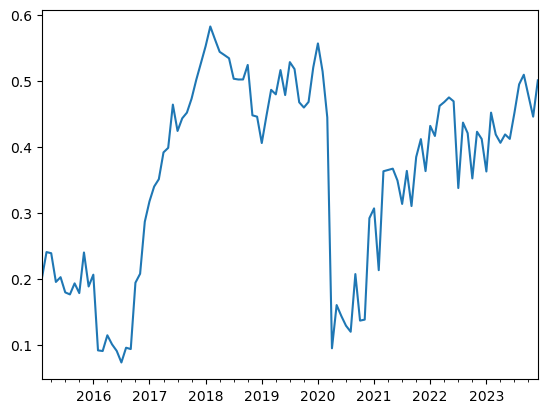

In [29]:
cushion_history["TUR"].plot()

<Axes: >

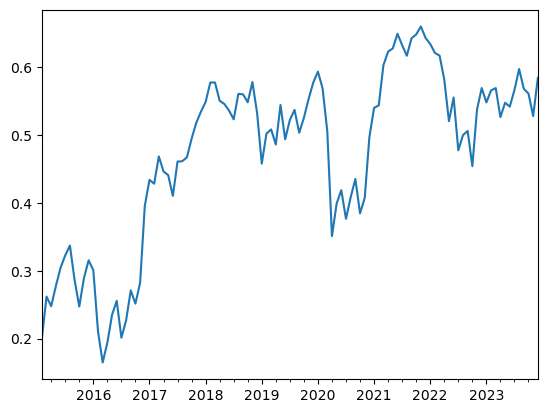

In [30]:
cushion_history["FIN"].plot()

<Axes: >

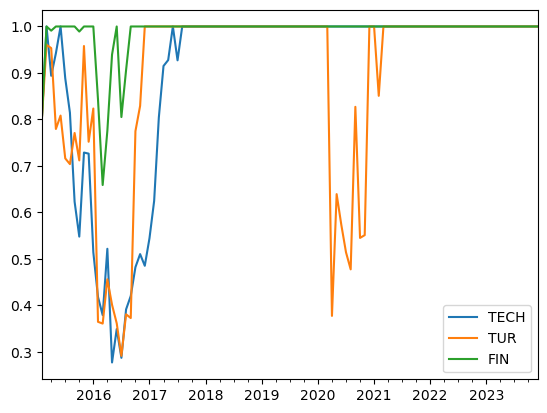

In [31]:
risky_w_history.plot()

<Axes: >

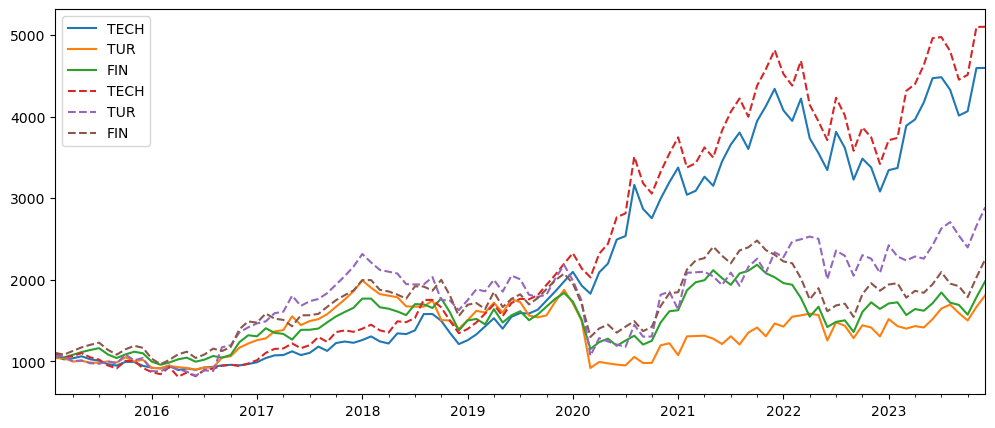

In [32]:
btr = erk.run_cppi(ind_return[["TECH", "TUR", "FIN"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [33]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
TECH,0.180832,0.226171,0.371395,3.505029,0.083189,0.102567,0.648869,-0.290002
TUR,0.064725,0.287160,-0.773027,7.109449,0.137213,0.178700,0.117277,-0.538358
FIN,0.073093,0.246859,-0.328721,3.699695,0.113693,0.146800,0.169579,-0.377116


In [34]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
TECH,0.190142,0.243564,0.190558,2.916457,0.094373,0.108400,0.639697,-0.290002
TUR,0.119523,0.349160,0.361680,6.679916,0.132541,0.186700,0.249093,-0.538358
FIN,0.084063,0.255693,-0.284262,3.520876,0.116406,0.149167,0.205457,-0.377116


# Drawdowns 
Constantly updating the floor

<Axes: >

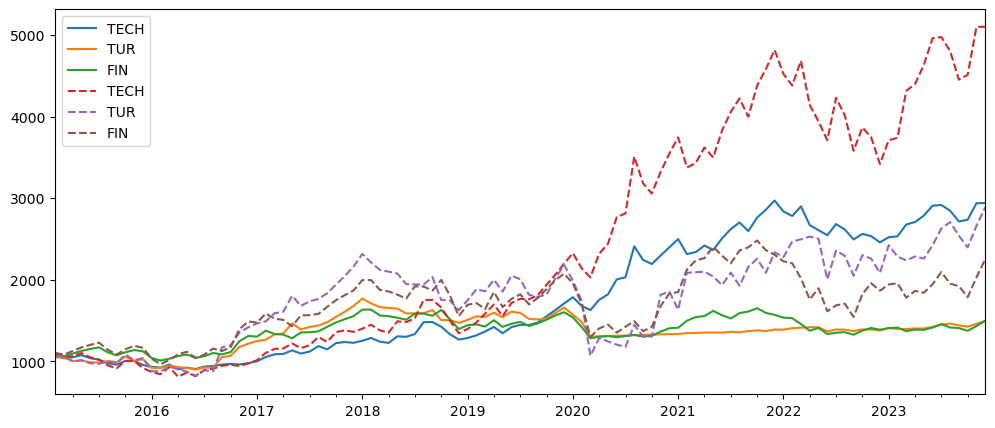

In [35]:
btr = erk.run_cppi(ind_return[["TECH", "TUR", "FIN"]], drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [36]:
erk.summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
TECH,0.120959,0.149833,0.590708,-0.172428
TUR,0.040998,0.119986,0.089066,-0.262588
FIN,0.037953,0.124362,0.062086,-0.214720


In [37]:
erk.summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
TECH,0.190142,0.243564,0.639697,-0.290002
TUR,0.119523,0.349160,0.249093,-0.538358
FIN,0.084063,0.255693,0.205457,-0.377116


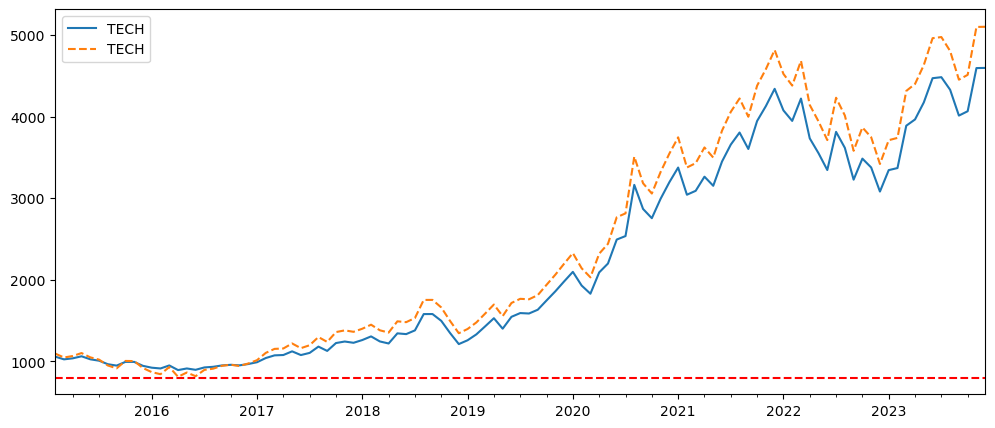

In [38]:
btr = erk.run_cppi(ind_return[["TECH"]])
ax = btr["Wealth"].plot(figsize=(12,5))
btr["Risky Wealth"].plot(ax=ax, style="--")
ax.axhline(y=floor_value, color='r', linestyle='--')